<a href="https://colab.research.google.com/github/amey-joshi/am/blob/master/p4/paper4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
**Image registration** is finding a geometrical transformation mapping one image to another. One of the images in the image registration problem is called the **reference image** or the **model**. The other one is called the **test image**. There are several situations in which image registration is needed.

- Suppose we want to track a person in a video. We are given his photograph. Then image registration allows us to map the photgraph with a sequence of moving pictures of the same person in the video. Note that it is not necessary that one maps the entire reference image to the test image. One may just want to map the face of the person.
- A satellite has taken photographs of a certain area on the earth's surface. It takes similar photographs at different times or seasons. They photographs may not be, and usually will not be, identical. Image registration helps us map one to the other.
- A certain portion of a patient's body is scanned by Ultrasound and Magnetic Resonance Imaging. Mapping one image to another involves image registration.

From the description of the image registration problem it appears that the only way to find a transformation between the reference and the test images is to extract the features of both and build a mapping between them. While this is definitely one way to do it, there are other techniques as well. This tutorial is based on the paper [Optimization of Mutual Information for Multiresolution Image Registration](https://infoscience.epfl.ch/record/63070/files/thevenaz0003.pdf) by Philippe Thévenaz and Michael Unser. It describes an algorithm to register images based on their information content.



# Mutual information

We begin with introducing a few terms from probability theory and information theory. We will illustrate them by applying them to simple, binary images.

## A. Definitions

### Parzen window
Often times one has to infer the probability distribution of a population from a sample drawn from it. The population may not be following one of the standard distributions, all of which are described in terms of a (small) finite number of **parameters**. For example, the binomial distribution is described by a single parameter, the probability of success or a gaussian (normal) distribution is described by its mean and variance. When it is no longer possible to fit any of these 'standard distributions' to the data, we take recourse to finding distribution without using parameters. This is also called non-parametric estimation of probability density function or **kernel density estimation**.

Suppose that we are given a sample $x_1, \ldots, x_N$ from a population with an unknown density $f$. We can estimate $f$ using the expression
$$\tag{1}
\hat{f}_h(x) = \frac{1}{nh}\sum_{i=1}^N w\left(\frac{x - x_i}{h}\right),
$$
where $w$ is a function, called the **kernel**, such that $w(x) \ge 0$ for all $x \in \mathbb{R}$. The parameter $h$ is called the **smoothing paramters** or **bandwidth**. We will explain its role with the particular example we next consider. The function $f$ is also called the **Parzen window** or the **Parzen estimate** of the density $f$. Usually $h$ depends on the sample size and is written as $\varepsilon(N)$. Equation (1) then becomes,
$$\tag{2}
\hat{f}_h(x) = \frac{1}{n}\sum_{i=1}^N \frac{1}{\varepsilon(N)}w\left(\frac{x - x_i}{\varepsilon(N)}\right).
$$
We may also assume that
$$\tag{3}
\int_{-\infty}^\infty w(x)dx = 1.
$$
Before discussing more about Parzen windows, we first construct one such.



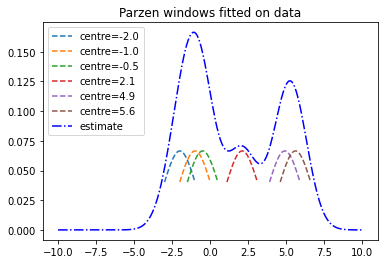

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# A sample from a population with unknown density
X = np.array([-2, -1, -0.5, 2.1, 4.9, 5.6])
# Number of data points
N = len(X)
# Let us assume a width of 1. 
h = 1

def draw_window(x):
  u = np.linspace(x - 1, x + 1, 30)
  v = np.exp(-0.5 * ((u - x)/h)**2)/np.sqrt(2 * np.pi) # standard normal density
  plt.plot(u, v/(N*h), linestyle = 'dashed', label = f'centre={x}')

for x in X:
  draw_window(x)

kde = stats.gaussian_kde(X)
xeval = np.linspace(-10, 10, num = 200)
yeval = np.zeros(len(xeval))

for x in X:
  yeval = yeval + np.exp(-0.5 * ((xeval - x)/h)**2)/np.sqrt(2 * np.pi)

plt.plot(xeval, yeval/(N*h), linestyle = '-.', color = 'blue', label = 'estimate')
plt.title('Parzen windows fitted on data')
plt.legend()
plt.show()


From the figure above, it is quite clear that $\hat{f}_h(x)$ has a peak at $x$. Wherever the peaks are close by the final estimate shown in blue tends to rise higher. 

When we have a large number of data points, that is, when $N$ is large, we can select a relatively smaller $\varepsilon(N)$ because we can get information from a small enough neighbourhood of $x$. The opposite is true when $N$ is small.

### Histogram estimation
Let an image be defined over a domain $V^c$ in $\mathbb{R}^n$. By a domain we just mean a subset of $\mathbb{R}^n$. The superscript $^c$ indicates that the domain is continuous. Let $V$ be a discrete set of samples of $V^c$. Then a digital image is defined over $V$ while its continuous representation is defined over $V^c$.

If $x \in V^c$, let $f_R(x)$ denote the *reference image* and $f_T(x)$ denote the *test image*. The goal of image registration is to align $f_T$ along $f_R$. Let $g(x; \mu_1, \mu_2, \ldots)$ be a geometric transformation, where $\mu_1, \mu_2, \ldots$ are some parameters. An example of such a transformation is $g(x; a, b) = ax + b$. 

We want to find out how close is $f_T(g(x; \mu_1, \mu_2, \ldots)$ to $f_R(x)$. Let $L_R$ and $L_T$ be the discrete set of image intensities associated with $f_R$ and $f_T$. Then we define the joint Parzen histogram as
$$\tag{1}
h(\iota, \kappa; \mu) = \frac{1}{\varepsilon_T\varepsilon_R}\sum_{x_i \in V}w\left(\frac{\iota - f_T(g(x_i, \mu))}{\varepsilon_T}\right)\cdot w\left(\frac{\kappa - f_R(x_i)}{\varepsilon_R}\right).
$$
Let us understand this equation. It is a product of two Parzen windows. One of them is centred at $f_R(x_i)$ and has width $\varepsilon_R$. The other is centred at $f_T(g(x;\mu))$ and has width $\varepsilon_T$. $\mu$ is the vector $(\mu_1, \mu_2, \ldots)$. $h(\iota, \kappa; \mu)$ will have a large value when both the terms on the right have a large value. That will happen only when the intensity of the reference image at $x_i$ is similar to the intensity of the test image at $g(x_i; \mu)$. 

Why is $h(\iota, \kappa; \mu)$ called a histogram? It is because the values of the functions $f_R$ and $f_T$, which vary continuously, are now distributed over several discrete bins $(\iota, \kappa)$. The binning is done by a single function $w$.

We know that histograms are a reflection of the underlying probability density. Therefore, it comes as no surprise that $h(\iota, \kappa; \mu)$ is proportional to the discrete probability function $p(\iota, \kappa; \mu)$. In fact, we can always write
$$\tag{2}
p(\iota, \kappa; \mu) = \alpha(\mu)h(\iota, \kappa; \mu),
$$
where
$$\tag{3}
\alpha(\mu) = \left(\sum_{\iota, \kappa}h(\iota, \kappa; \mu)\right)^{-1}
$$
is just the normalization constant.


### Mutual information
Once we have the discrete probabilities the mutual information between the test and the reference images is
$$\tag{1}
S(\mu) = \sum_{\iota \in L_T}\sum_{\kappa \in L_R}p(\iota, \kappa; \mu)\log_2 p(\iota, \kappa; \mu)
$$
The code snippet below computes the mutual information for the example we are working with.


## B. Illustration

We will demonstrate the definitions introduced in the previous subsection by using them on a set of two small binary images. We will first create the two images.

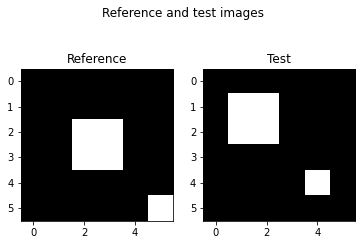

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

x = np.zeros(36)
x[14] = x[15] = x[20] = x[21] =  x[35] = 128
ref = Image.new('1', (6, 6))
ref.putdata(x)

y = np.zeros(36)
y[7] = y[8] = y[13] = y[14] = y[28] = 128
tst = Image.new('1', (6, 6))
tst.putdata(y)

plt.figure()
plt.suptitle('Reference and test images')
p1 = plt.subplot(121)
p1.set_title('Reference')
plt.imshow(ref)

p2 = plt.subplot(122)
p2.set_title('Test')
plt.imshow(tst)

plt.show()

We next select the square pulse as a Parzen window. That is
$$\tag{4}
w(\iota, \kappa) = \begin{cases}
1 & \;\text{if}\; |\iota| < 1/2 \;\text{and}\; |\kappa| < 1/2 \\
0 & \;\text{otherwise.}
\end{cases}
$$

In [0]:
def sq_pulse(x):
  if np.abs(x) < 0.5:
    return 1
  else:
    return 0


For the moment we will not perform any geometrical transformation. We will just 
illustrate the joint histogram. That is, $g(x; \mu) = x$. Further, we note that there are only two levels in the images, $0$ and $128$. Therefore, there are only four bins $(0, 0), (128, 0), (0, 128)$ and $(128, 128)$. The image itself is stored as a binary. Therefore, these levels are $(0, 0), (1, 0), (0, 1)$ and $(1, 1)$ respectively. For each of these values, we must compute the joint Parzen histogram.

In [0]:
h = np.zeros((2, 2), dtype = np.float)

rd = np.asarray(ref)
td = np.asarray(tst)

# Compute h[0, 0] corresponding to bin (0, 0)
for i in range(6):
  for j in range(6):
    h[0, 0] = h[0, 0] + sq_pulse(0 - rd[i, j]) * sq_pulse(0 - td[i, j])

# Compute h[1, 0] corresponding to bin (1, 0)
for i in range(6):
  for j in range(6):
    h[1, 0] = h[1, 0] + sq_pulse(1 - rd[i, j]) * sq_pulse(0 - td[i, j])

# Compute h[0, 1] corresponding to bin (0, 1)
for i in range(6):
  for j in range(6):
    h[0, 1] = h[0, 1] + sq_pulse(0 - rd[i, j]) * sq_pulse(1 - td[i, j])

# Compute h[1, 1] corresponding to bin (1, 1)
for i in range(6):
  for j in range(6):
    h[1, 1] = h[1, 1] + sq_pulse(1 - rd[i, j]) * sq_pulse(1 - td[i, j])

print('The joint histograms is:')
print(h)

# The sum of all elements in the histogram is
total = sum(sum(h))
# It comes as no surprise that it is 36. It is now easy to compute the discrete
# probabilities.
dp = h/total
print('----------------------------------------------------------------')
print('The discrete probabilities are:')
print(dp)
print('----------------------------------------------------------------')
mi = -sum(sum(np.multiply(dp, np.log2(dp))))
print(f'The mutual information is {mi}.')

The joint histograms is:
[[27.  4.]
 [ 4.  1.]]
----------------------------------------------------------------
The discrete probabilities are:
[[0.75       0.11111111]
 [0.11111111 0.02777778]]
----------------------------------------------------------------
The mutual information is 1.1593149303752663.


## C. Partition of Unity
From the discrete Parzen probability introduced in the section <a href="Histogram estimation">Histogram estimation</a> we can readily compute the two marginal probabilities,
$$
\begin{eqnarray}
p_T(\iota; \mu) &=& \sum_{\kappa \in L_R}p(\iota, \kappa; \mu) \tag{1} \\
p_R(\kappa; \mu) &=& \sum_{\iota \in L_T}p(\iota, \kappa; \mu). \tag{2}
\end{eqnarray}
$$
An unfortunate consequence of this method is that the marginal probability $p_R$ for the reference image also depends on the parameters $\mu$ of the geometric transformation $g(x; \mu)$. Let us find out if we can avoid the dependency. From equation (2)in the section <a href="Histogram estimation">Histogram estimation</a> we get
$$\tag{3}
p_R(\kappa;\mu) = \alpha(\mu)\sum_{\iota \in L_T}h(\iota, \kappa; \mu).
$$
Using the definition of $h$ from equation (1) in the section <a href="Histogram estimation">Histogram estimation</a>,
$$\tag{4}
p_R(\kappa;\mu) = \alpha(\mu)\sum_{\iota \in L_T}\frac{1}{\varepsilon_T\varepsilon_R}\sum_{x_i \in V}w\left(\frac{\iota - f_T(g(x_i, \mu))}{\varepsilon_T}\right)\cdot w\left(\frac{\kappa - f_R(x_i)}{\varepsilon_R}\right).
$$
Interchanging the sums,
$$\tag{5}
p_R(\kappa;\mu) = \frac{\alpha(\mu)}{\varepsilon_T\varepsilon_R}\sum_{x_i \in V}\sum_{\iota \in L_T}w\left(\frac{\iota - f_T(g(x_i, \mu))}{\varepsilon_T}\right)\cdot w\left(\frac{\kappa - f_R(x_i)}{\varepsilon_R}\right).
$$
The left hand side will not depend on $\mu$ if we insist that
$$\tag{6}
\sum_{\iota \in L_T}w\left(\frac{\iota - f_T(g(x_i, \mu))}{\varepsilon_T}\right) = 1
$$
**for all** window functions $w$. In that case,
$$\tag{7}
p_R(\kappa;\mu) = \frac{\alpha(\mu)}{\varepsilon_T\varepsilon_R}\sum_{x_i \in V}w\left(\frac{\kappa - f_R(x_i)}{\varepsilon_R}\right).
$$
It is easy to see that
$$\tag{8}
\frac{1}{\alpha(\mu)} = \frac{1}{\varepsilon_T\varepsilon_R}\sum_{x_i \in V}\left\{\sum_{\iota \in L_T}w\left(\frac{\iota - f_T(g(x_i, \mu))}{\varepsilon_T}\right)\cdot \sum_{\kappa \in L_R}w\left(\frac{\kappa - f_R(x_i)}{\varepsilon_R}\right)\right\}
$$
Using the condition (6), we get
$$\tag{9}
\frac{1}{\alpha(\mu)} = \frac{1}{\varepsilon_T\varepsilon_R}\sum_{x_i \in V} 1.
$$
The sum is equal to the number of elements in $V$, also called its **cardinality** and denoted by $\text{card}(V)$. Therefore,
$$\tag{10}
\alpha = \frac{\varepsilon_T\varepsilon_R}{\text{card}(V)}.
$$
Thus, the normalization constant $\alpha$ too is independent of $\mu$, which is the reason we dropped showing it in equation (10). From equation (7) and (10), we have
$$\tag{11}
p_R(\kappa) = \frac{1}{\text{card}(V)}\sum_{x_i \in V}w\left(\frac{\kappa - f_R(x_i)}{\varepsilon_R}\right).
$$
Condition (6) on the window functions is called **partition of unity**.


## D. Partial overlap

We will use the idea of partial overlap only when we get to computation of gradients. The reader may want to return to this section when the need arises.

In order to find mutual information between two images there should be at least some overlap between their domains. Recall the notation $V^c_R$ and $V^c_T$ for domains of the reference and test images in the section <a href="Histogram estimation">Histogram estimation.</a> Also recall that the geometric transformation $g(x;\mu)$ attempts to align $V_T$ along $V_R$. An overlap between the domains of the reference and test images is thus,
$$\tag{1}
V^c = V_R^c \cap g^{-1}\left(V_T^x; \mu\right).
$$
Clearly, $V^c$ can at most be as large as $V_R^c$. In order to compute the discrete Parzen histogram we sample the continuous domain $V^c$ to a discrete set $V$ of values. Because $V$ is discrete,
$$\tag{2}
\frac{dV}{d\mu} = 0, \;\text{almost everywhere.}
$$
The term 'almost everywhere' comes from a branch of mathematics called **measure theory**. It is analogous to the idea of an event having probability zero.


## E. B-splines

We will use B-splines as window functions. They are guaranteed for form partition of unity as one can confirm on page 10 of [de Boor's paper.](https://www.cs.unc.edu/~dm/UNC/COMP258/Papers/bsplbasic.pdf) They are defined recursively as
$$
\begin{eqnarray}
\beta^n(x) &=& (\beta^{n-1} \star \beta^{0})(x) \tag{1} \\
\beta^0(x) &=& \frac{1}{2}\left(\text{sgn}\left(x + \frac{1}{2}\right)\text{sgn}\left(x - \frac{1}{2}\right)\right), \tag{2} \\
\end{eqnarray}
$$
where
$$\tag{3}
\text{sgn}(x) = \begin{cases}
-1 & \;\text{if}\; x < 0 \\
 0 & \;\text{if}\; x = 0 \\
+1 & \;\text{if}\; x > 0 
\end{cases}
$$
We will also use B-splines to represent a discrete image as a continuous function. 

<font color="blue">Attention Ibraheem: Please insert the link to tutorial 1 after you finalize its location.</font>

# Multi-resolution

## A. Image model

We insist on the following characteristics of an image model.

1. It should allow us to build a continuous function from the discrete samples.
2. Given a continuous representation of an image, we should be able to sample it in such a way that reconstructing the continuous representation should give us a function that is close to the one we started with.

This tutorial uses the B-spline model. In particular, we express the continuous image function $f$ as
$$\tag{1}
f(x) = \sum_{x_i \in V}c(x_i)\beta^n(x - x_i),
$$
where the coefficients $c(x_i)$ depend on the discrete samples $f_i$ of the image and $\beta^n$ are B-splines of order $n$. If $x = (x_1, \ldots, x_m) \in \mathbb{R}^m$ then the separability of splines ensures that
$$\tag{2}
\beta^n(x) = \beta^n(x_1) \cdots \beta^n(x_m)
$$

## B. Model degree

By model degree we mean the degree of the spline polynomials. Very low degree causes blocking while very high degree causes ringing. A compromise between the extremes is the choice $n = 3$, which corresponds to the cubic splines.

## C. Grey cone

Multi-resolution analysis means processing an image at multiple levels of increasingly finer (or coarser) resolutions. At each stage of resolution we find the mutual information between images. The geometric multi-resolution is called **image pyramid** while the gray-level multi-resolution is called the **grey cone**. At very coarse levels, there could be fewer data points as compared to the number of grey levels. On the other hand, at finer levels we may have too few gray levels for the available data points. To balance these extreme as constant ratio between the two is suggested.


## D. Underlying assumptions

The [paper](https://infoscience.epfl.ch/record/63070/files/thevenaz0003.pdf) assumes that most of the image signal is concentrated in the lower spatial frequencies which are preserved across resolutions. Therefore, its proposed algorithm first carries out registration at coarser resolution and as it goes to finer resolution the results are only adjusted slightly towards the final registration.

The pseudo-quantization mentioned in the [paper](https://infoscience.epfl.ch/record/63070/files/thevenaz0003.pdf) means a paucity of grey-levels at a certain geometrical resolution level. In such a situation, a conventional histogram puts all data points in a single bin. The image registration algorithm performs very poorly in such a situation. This is where the idea of using Parzen histogram becomes useful. Using cubic splines are Parzen window distributes data across bins.

The choice of cubic splines allows also ensures that

1. Empirical average computed over bins is identical with empirical average over data.
2. If $L$ is the discrete set of grey levels and $\sigma_L^2$ is the variance measured over bins, the variance over the set $V$ of values is $\sigma_V^2 = \varepsilon - \varepsilon^2/3$ where $
\varepsilon = \sigma_L^2$.

# Optimization

The reference and the test images are optimally aligned with each other when the mutual information between them is the least. This suggests that must develop an algorithm that selects a geometric transformation that minimizes the mutual information. This is where optimization comes into the picture. It proposes to carry out optimization at successively finer levels of resolution. This is where 'multi-resolution' comes into the picture.

Optimization always involves finding extrema of functions. In order to find them, we need to evaluate their derivatives. In this section, we will develop expressions for derivatives of mutual information $S$ and their simplification for sake of computations.

## A. Criterion model
We first express the mutual information $S$, defined by equation (1) in the section <a href="Mutual information">Mutual information</a> as a Taylor series,
$$\tag{1}
S(\mu) = S(\nu) + \sum_{i=1}^m\frac{\partial S}{\partial\mu_i}(\nu)(\mu_i - \nu_i) + \frac{1}{2}\sum_{i,j=1}^m\frac{\partial^2 S}{\partial\mu_i\partial\mu_j}(\nu)(\mu_i - \nu_i)(\mu_j - \nu_j) + \cdots.
$$
Recall that $\mu, \nu$ are the vectors of the parameters of the geometric transformations. We assume that there are $m$ such parameters and therefore $\mu, \nu \in \mathbb{R}^m$.

We shall simplify the Taylor expansion by assuming that terms of $O(||\mu - \nu||^3)$ can be ignored.

## B. Gradient
The second term in the Taylor expansion of the mutual information is a product of gradient of $S$ and the vector $\mu - \nu$. We now consider an expression for the gradient.

$$\tag{1}
\nabla S = \frac{\partial S}{\partial\mu} = \left(\frac{\partial S}{\partial\mu_1}, \ldots, \frac{\partial S}{\partial\mu_m}\right).
$$
We can simplify the expression for $\nabla S$ if we take into account the following assumptions:

1. Parzen windows satisfy partition of unity, as a result of which,
2. $\alpha$ is independent of $\mu$ and 
3. 
$$\tag{2}
h_R(\kappa; \mu) = \sum_{\iota \in L_T} h(\iota, \kappa; \mu).
$$
We then get
$$\tag{3}
\nabla S = -\sum_{\iota \in L_T}{\kappa \in L_R} \nabla p \cdot
\log_2\left(\frac{p(\iota, \kappa; \mu)}{p_T(\iota; \mu)}\right).
$$
From equations (1) and (2) in the section <a href="Histogram estimation">Histogram estimation</a> we get
$$\tag{4}
\nabla p = \frac{1}{\text{card}(V)}\sum_{x_i \in V}\left(\beta^m\left(\frac{\kappa - f_R(x_i)}{\varepsilon_R}\right)\frac{\partial\beta^m}{\partial\xi}\Big|_{\xi_0}\times\frac{1}{\epsilon_T}(-\nabla f_T(t_0)\cdot\nabla g\right),
$$
where
$$\tag{5}
\xi_0 = \frac{\iota - f_T(g(x;\mu))}{\varepsilon_T}
$$
and
$$\tag{6}
t_0 = g(x_i; \mu)
$$
We can use the properties of B-splines to write
$$\tag{7}
\frac{\partial\beta^m}{\partial\xi} = \beta^{m-1}\left(\xi + \frac{1}{2}\right) - \beta^{m-1}\left(\xi - \frac{1}{2}\right)
$$
The gradient of the test image is
$$\tag{8}
\frac{df_T}{dt} = \sum_{x_i \in V}c_{x_i}\frac{d\beta^n}{du}\Big|_{u = t - x_i}.
$$
Finally,
$$\tag{9}
\nabla p_T = \frac{1}{\text{card}(V)}\sum_{x_i \in V}\left(\frac{\partial\beta^m}{\partial\xi}\Big|_{\xi_0}\times\frac{1}{\epsilon_T}(-\nabla f_T(t_0)\cdot\nabla g\right)
$$

## C. Hessian
The hessian of $S$ is defined as the matrix $\nabla^2S$ whose general term is
$$\tag{1}
\left(\nabla^2S\right)_{ij} = \frac{\partial^2S}{\partial\mu_i\partial\mu_j},
$$
where $1 \le i, j \le m$. Its simplified form is
$$\tag{2}
\frac{\partial^2S}{\partial\mu_i\partial\mu_j} \approx \frac{1}{\ln 2}\left\{\sum_{\iota \in L_T}\frac{\partial p_T}{\partial\mu_i}\frac{\partial p_T}{\partial\mu_j}\frac{1}{p_T(\iota;\mu)} - \sum_{\iota \in L_T}\sum_{\kappa \in L_R}\frac{\partial p}{\partial\mu_i}\frac{\partial p}{\partial\mu_j}\frac{1}{p(\iota, \kappa;\mu)}\right\}
$$
Essentially, we have expressed the hessian in terms of first derivatives alone. We computed the first derivatives while computing the gradient.


## D. Standard optimizers
Some of the common methods of finding extrema of functions are discussed in this section.

Each technique is illustrated with a snippet of the code. It is written in the simplest possible way and it is in no way a substitute to well-tested and well-writted FORTRAN/C code available in the python module scipy.optimize.

### Gradient descent
It is a very old method, proposed in 1847 by the French mathematician Augustin-Louis Cauchy. It searches a local extremum by proceeding along the direction where the gradient is the most.

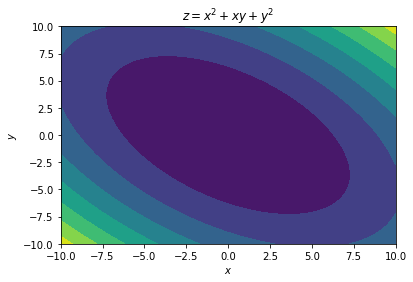

Found an extremum.
Number of iterations = 148
Optimum points = [1.05419835e-05 1.05419835e-05]


In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the function f(x, y) = x^2 + xy + y^2.
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
xs, ys = np.meshgrid(x, y, sparse = True)
z = xs**2 + xs*ys + ys**2
plt.contourf(x, y, z)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = x^2 + xy + y^2$')
plt.show()

# Find its local minimum. Since f is a convex function the local
# minimum is also the global minimum.
def gradz_dot_dh(r, dh):
    # gradient of f is (2x + y, x + 2y)
    gradz = [2*r[0] + r[1], r[0] + 2*r[1]]

    return np.dot(gradz, dh)

def euclidean_dist(r1, r2):
    return np.sqrt((r1[0] - r2[0])**2 + (r1[1] - r2[1])**2)

threshold = 0.000001
max_iter = 10000
step = [0.01, 0.01]

prev = [0.1, 0.1]
n = 0
while n < max_iter:
    n = n + 1
    curr = prev - gradz_dot_dh(prev, step)
    if euclidean_dist(prev, curr) < threshold:
        print('Found an extremum.')
        break
    else:
        prev = curr

print(f'Number of iterations = {n}')
print(f'Optimum points = {curr}')


### Newton's method.
Newton's method is similar to the gradient descent except that the gradient is scaled by the Hessian determinant of the function evaluated at the point at which we are exploring the function's landscape.

In [0]:
import numpy as np

def gradz_dot_dh(r, dh):
    # gradient of f is (2x + y, x + 2y)
    gradz = [2*r[0] + r[1], r[0] + 2*r[1]]

    return np.dot(gradz, dh)

def hessian(r):
  # In the case of this example, the Hessian is a constant.
  return 3

def euclidean_dist(r1, r2):
    return np.sqrt((r1[0] - r2[0])**2 + (r1[1] - r2[1])**2)

threshold = 0.000001
max_iter = 10000
step = [0.01, 0.01]

prev = [0.1, 0.1]
n = 0
while n < max_iter:
    n = n + 1
    curr = prev - gradz_dot_dh(prev, step)/hessian(prev)
    if euclidean_dist(prev, curr) < threshold:
        print('Found an extremum.')
        break
    else:
        prev = curr

print(f'Number of iterations = {n}')
print(f'Optimum points = {curr}')

Found an extremum.
Number of iterations = 395
Optimum points = [3.42215675e-05 3.42215675e-05]


Gradient descent is known to converge to a local extremum although the rate of convergence may be quite slow. On the other hand, although Newton's method can be very fast if we are close to the extremum it sometimes does not converge to a local extremum. In the worst case it is known to diverge away from the extremum or settle at a saddle point.

## E. Marquardt–Levenberg strategy
Marquardt and Levenberg proposed an optimization algorithm that combines the certainty of gradient descent with the efficiency of Newton's method. The scaling by Hessian in Newton's method is replaced by scaling with the quantity
$$\tag{1}
H^\prime_{ij} = H_{ij}(1 + \lambda\delta_{ij}),
$$
where $\lambda$ is a (usually adaptive) constant and $\delta_{ij}$ is the Kronecker delta.

The code snippet in the next cell demonstrates a simplified version of this algorithm. It seeks to find the extrema of the function
$$
f(x, y) = x^4 + xy + y^4.
$$
$f$ has two minima $(0.5, -0.5)$ and $(-0.5, 0.5)$. We first plot the function and then find one of the minima. The algorithm does not select a different $\lambda$ for each iteration. We have kept it equal to $2$ all through out.

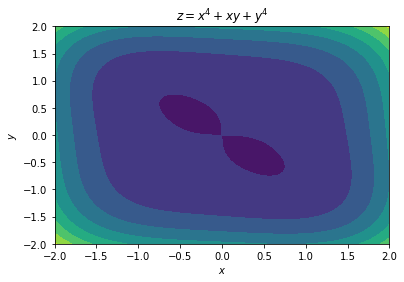

Found an extremum.
Number of iterations = 1003
Optimum points = [ 0.49939256 -0.49939236]


In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the function f(x, y) = x^4 + xy + y^4.
L = 2
x = np.linspace(-L, L, 200)
y = np.linspace(-L, L, 200)
xs, ys = np.meshgrid(x, y, sparse = True)
z = xs**4 + xs*ys + ys**4
plt.contourf(x, y, z)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$z = x^4 + xy + y^4$')
plt.show()


def gradz_dot_dh(r, dh):
    gradz = [4 * r[0]**3 + r[1], r[0] + 4 * r[1]**3]

    return np.array([gradz[0] * dh[0], gradz[1] * dh[1]])
    
def hessian(r, lmbd):
    return (1 - lmbd) * 12 * r[0]**2 * r[1]**2 - 1

def euclidean_dist(r1, r2):
    return np.sqrt((r1[0] - r2[0])**2 + (r1[1] - r2[1])**2)

threshold = 0.00001
max_iter = 10000
step = [0.01, 0.01]

prev = [2, 1]
n = 0
lmbd = 2

while n < max_iter:
    n = n + 1
    hp = hessian(prev, lmbd)
    delta = gradz_dot_dh(prev, step)
    curr = prev + delta/hp
    if euclidean_dist(prev, curr) < threshold:
        print('Found an extremum.')
        break
    else:
        prev = curr

print(f'Number of iterations = {n}')
print(f'Optimum points = {curr}')


# Experiments
In this section, we will build a number of code snippets that will be useful while constructing the final algorithm. Implementing the full algorithm is quite challenging for several reasons:
1. Ideally, the algorithm should infer a geometric transformation that aligns the test image to the reference image. However, the space of such functions is very large and the paper throws no light on how we can narrow it. In order to illustrate the algorithm, we have assumed a linear transformation.
2. The simple optimization algorithm know the closed form of the function they are optimizing. They also know their gradient. The implementation is more challenging when we not only do not know $g$ but neither do we know its derivative/gradient. $\nabla g$ is a factor in equations (4) and (9) in the section <a href="Gradient">Gradient</a>.

## 1. Generate the image model
Refer to the section <a href="Image model">Image model</a> for the meaning of the term 'image model'. It just means building the B-spline transform of the image. The code snippet in the next cell shows how to apply the cubic B-spline filter to the binary images we will use for our experiment.


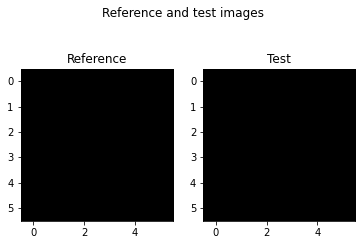

Although the images appear black, the data is not all zeros.
Reference image's data: 
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.02777778 0.13888889 0.13888889 0.02777778 0.        ]
 [0.         0.13888889 0.69444444 0.69444444 0.13888889 0.        ]
 [0.         0.13888889 0.69444444 0.69444444 0.13888889 0.        ]
 [0.         0.02777778 0.13888889 0.13888889 0.05555556 0.13888889]
 [0.         0.         0.         0.         0.13888889 0.69444444]]
Transformed image's data: 
[[0.02777778 0.13888889 0.13888889 0.02777778 0.         0.        ]
 [0.13888889 0.69444444 0.69444444 0.13888889 0.         0.        ]
 [0.13888889 0.69444444 0.69444444 0.13888889 0.         0.        ]
 [0.02777778 0.13888889 0.13888889 0.05555556 0.11111111 0.02777778]
 [0.         0.         0.         0.11111111 0.44444444 0.11111111]
 [0.         0.         0.         0.02777778 0.11111111 0.02777778]]


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, misc
from PIL import Image
import math

# The cubic B-spline filter.
b_1_3 = [1/6, 2/3, 1/6]
csf = np.outer(b_1_3, b_1_3)

x = np.zeros(36)
x[14] = x[15] = x[20] = x[21] = x[35] = 128
ref = Image.new('1', (6, 6))
ref.putdata(x)

y = np.zeros(36)
y[7] = y[8] = y[13] = y[14] = y[28] = 128
tst = Image.new('1', (6, 6))
tst.putdata(y)

x1 = signal.convolve2d(ref, csf, mode = 'same', boundary = 'symm')
ref1 = Image.new('1', (6, 6))
ref1.putdata(x1)

y1 = signal.convolve2d(tst, csf, mode = 'same', boundary = 'symm')
tst1 = Image.new('1', (6, 6))
tst1.putdata(y1)

plt.figure()
plt.suptitle('Reference and test images')
p1 = plt.subplot(121)
p1.set_title('Reference')
plt.imshow(ref1)

p2 = plt.subplot(122)
p2.set_title('Test')
plt.imshow(tst1)

plt.show()

print('Although the images appear black, the data is not all zeros.')
print("Reference image's data: ")
print(x1)
print("Transformed image's data: ")
print(y1)


## 2. Decimation of images
In order to build a multi-resolution pyramid, we must decimate the images successively. We are working with rather small images. Therefore, we will carry out only one level of decimation.

In [0]:
# Do not run this code in isolation. Run the previous cell before running this 
# one.
print(x1.size)

rd = np.zeros((3, 3))
td = np.zeros((3, 3))

x1.reshape((6, 6))
y1.reshape((6, 6))

# Decimating the image 'by hand'. The decimate function in the package signal
# doesn't seem to work on small images.
for i in range(3):
  for j in range(3):
    rd[i, j] = x1[2*i, 2*j]
    td[i, j] = y1[2*i, 2*j]


36


## 3. Build Parzen window
We built a Parzen window previously. But it was based on a square pulse. Now we will build it based on cubic B-splines.

In [0]:
def mu(x):
    if x < 0:
      return 0
    else:
      return 1

def beta3(x):
    b_0 = np.multiply(pow(x + 2, 3), mu(x + 2))/6
    b_1 = -2/3 * np.multiply(pow(x + 1, 3), mu(x + 1))
    b_2 = np.multiply(pow(x, 3), mu(x))
    b_3 = -2/3 * np.multiply(pow(x - 1, 3), mu(x - 1))
    b_4 = np.multiply(pow(x - 2, 3), mu(x - 2))/6

    return b_0 + b_1 + b_2 + b_3 + b_4

alpha = np.sqrt(3) - 2

def eta(x):
    sum = 0
    for k in range(-5, 6):
        sum = sum + math.pow(alpha, abs(k)) * beta3(x - k)

    return sum


## 4. Compute joint Parzen histogram

It is evident from the output of step 1 'Generate the image model' that there are four distinct values of pixel in the spline transform of the image, $0, 0.02777778, 0.13888889$ and $0.69444444$. Let us, therefore, choose the bins of the histogram to be defined by the boundaries $0, 0.1, 0.2, 0.7$. Thus the join histogram will have sixteen levels.

In [0]:
h = np.zeros((4, 4), dtype = np.float)

###############################################################################
# Compute h[0, 0] corresponding to bin (0, 0)
for i in range(3):
  for j in range(3):
    h[0, 0] = h[0, 0] + eta(0 - rd[i, j]) * eta(0 - td[i, j])

# Compute h[1, 0] corresponding to bin (0.1, 0)
for i in range(3):
  for j in range(3):
    h[1, 0] = h[1, 0] + eta(0.1 - rd[i, j]) * eta(0 - td[i, j])

# Compute h[2, 0] corresponding to bin (0.2, 0)
for i in range(3):
  for j in range(3):
    h[2, 0] = h[2, 0] + eta(0.2 - rd[i, j]) * eta(0 - td[i, j])

# Compute h[3, 0] corresponding to bin (0.7, 0)
for i in range(3):
  for j in range(3):
    h[3, 0] = h[3, 0] + eta(0.7 - rd[i, j]) * eta(0 - td[i, j])

###############################################################################
# Compute h[0, 1] corresponding to bin (0, 0.1)
for i in range(3):
  for j in range(3):
    h[0, 1] = h[0, 1] + eta(0 - rd[i, j]) * eta(0.1 - td[i, j])

# Compute h[1, 1] corresponding to bin (0.1, 0.1)
for i in range(3):
  for j in range(3):
    h[1, 1] = h[1, 1] + eta(0.1 - rd[i, j]) * eta(0.1 - td[i, j])

# Compute h[2, 1] corresponding to bin (0.2, 0.1)
for i in range(3):
  for j in range(3):
    h[2, 1] = h[2, 1] + eta(0.2 - rd[i, j]) * eta(0.1 - td[i, j])

# Compute h[3, 1] corresponding to bin (0.7, 0.1)
for i in range(3):
  for j in range(3):
    h[3, 1] = h[3, 1] + eta(0.7 - rd[i, j]) * eta(0.1 - td[i, j])    

###############################################################################
# Compute h[0, 2] corresponding to bin (0, 0.2)
for i in range(3):
  for j in range(3):
    h[0, 2] = h[0, 2] + eta(0 - rd[i, j]) * eta(0.2 - td[i, j])

# Compute h[1, 2] corresponding to bin (0.1, 0.2)
for i in range(3):
  for j in range(3):
    h[1, 2] = h[1, 2] + eta(0.1 - rd[i, j]) * eta(0.2 - td[i, j])

# Compute h[2, 2] corresponding to bin (0.2, 0.2)
for i in range(3):
  for j in range(3):
    h[2, 2] = h[2, 2] + eta(0.2 - rd[i, j]) * eta(0.2 - td[i, j])

# Compute h[3, 2] corresponding to bin (0.7, 0.2)
for i in range(3):
  for j in range(3):
    h[3, 2] = h[3, 2] + eta(0.7 - rd[i, j]) * eta(0.2 - td[i, j])        

###############################################################################
# Compute h[0, 3] corresponding to bin (0, 0.7)
for i in range(3):
  for j in range(3):
    h[0, 3] = h[0, 3] + eta(0 - rd[i, j]) * eta(0.7 - td[i, j])

# Compute h[1, 3] corresponding to bin (0.1, 0.7)
for i in range(3):
  for j in range(3):
    h[1, 3] = h[1, 3] + eta(0.1 - rd[i, j]) * eta(0.7 - td[i, j])

# Compute h[2, 3] corresponding to bin (0.2, 0.7)
for i in range(3):
  for j in range(3):
    h[2, 3] = h[2, 3] + eta(0.2 - rd[i, j]) * eta(0.7 - td[i, j])

# Compute h[3, 3] corresponding to bin (0.7, 0.7)
for i in range(3):
  for j in range(3):
    h[3, 3] = h[3, 3] + eta(0.7 - rd[i, j]) * eta(0.7 - td[i, j])

print('The joint histograms is:')
print(h)

# The sum of all elements in the histogram is
total = sum(sum(h))
# It comes as no surprise that it is 36. It is now easy to compute the discrete
# probabilities.
dp = h/total
print('----------------------------------------------------------------')
print('The discrete probabilities are:')
print(dp)
print('----------------------------------------------------------------')
mi = -sum(sum(np.multiply(dp, np.log2(dp))))
print(f'The mutual information is {mi}.')

The joint histograms is:
[[2.54169993 2.589388   2.54258477 1.31113708]
 [2.54732935 2.6004278  2.55942248 1.35000315]
 [2.45647246 2.51365612 2.48074475 1.34216074]
 [1.09973013 1.15537111 1.17370739 0.79990769]]
----------------------------------------------------------------
The discrete probabilities are:
[[0.08182208 0.08335724 0.08185056 0.04220796]
 [0.0820033  0.08371264 0.0823926  0.04345913]
 [0.07907844 0.08091929 0.07985981 0.04320667]
 [0.03540237 0.03719356 0.03778384 0.02575052]]
----------------------------------------------------------------
The mutual information is 3.9031696967392007.


## 5. Compute the mutual information after translation
Let us now translate the image along the line $x + 1$. Note that the translation is applied to the test image, not the reference image. We observe that the translation does decrease the mutual information.

In [0]:
tdt = np.zeros((3, 3)) # tdt stands from test image which is translated.
for i in range(3):
  for j in range(3):
    i1 = i - 1
    j1 = j - 1
    if i1 >= 0 and j1 >= 0:
      tdt[i, j] = td[i1, j1]
    else:
      tdt[i, j] = 0

# We now repeat the computation of the mutual information.
ht = np.zeros((4, 4), dtype = np.float)

###############################################################################
# Compute ht[0, 0] corresponding to bin (0, 0)
for i in range(3):
  for j in range(3):
    ht[0, 0] = ht[0, 0] + eta(0 - rd[i, j]) * eta(0 - tdt[i, j])

# Compute ht[1, 0] corresponding to bin (0.1, 0)
for i in range(3):
  for j in range(3):
    ht[1, 0] = ht[1, 0] + eta(0.1 - rd[i, j]) * eta(0 - tdt[i, j])

# Compute ht[2, 0] corresponding to bin (0.2, 0)
for i in range(3):
  for j in range(3):
    ht[2, 0] = ht[2, 0] + eta(0.2 - rd[i, j]) * eta(0 - tdt[i, j])

# Compute ht[3, 0] corresponding to bin (0.7, 0)
for i in range(3):
  for j in range(3):
    ht[3, 0] = ht[3, 0] + eta(0.7 - rd[i, j]) * eta(0 - tdt[i, j])

###############################################################################
# Compute ht[0, 1] corresponding to bin (0, 0.1)
for i in range(3):
  for j in range(3):
    ht[0, 1] = ht[0, 1] + eta(0 - rd[i, j]) * eta(0.1 - tdt[i, j])

# Compute ht[1, 1] corresponding to bin (0.1, 0.1)
for i in range(3):
  for j in range(3):
    ht[1, 1] = ht[1, 1] + eta(0.1 - rd[i, j]) * eta(0.1 - tdt[i, j])

# Compute ht[2, 1] corresponding to bin (0.2, 0.1)
for i in range(3):
  for j in range(3):
    ht[2, 1] = ht[2, 1] + eta(0.2 - rd[i, j]) * eta(0.1 - tdt[i, j])

# Compute ht[3, 1] corresponding to bin (0.7, 0.1)
for i in range(3):
  for j in range(3):
    ht[3, 1] = ht[3, 1] + eta(0.7 - rd[i, j]) * eta(0.1 - tdt[i, j])    

###############################################################################
# Compute ht[0, 2] corresponding to bin (0, 0.2)
for i in range(3):
  for j in range(3):
    ht[0, 2] = ht[0, 2] + eta(0 - rd[i, j]) * eta(0.2 - tdt[i, j])

# Compute ht[1, 2] corresponding to bin (0.1, 0.2)
for i in range(3):
  for j in range(3):
    ht[1, 2] = ht[1, 2] + eta(0.1 - rd[i, j]) * eta(0.2 - tdt[i, j])

# Compute ht[2, 2] corresponding to bin (0.2, 0.2)
for i in range(3):
  for j in range(3):
    ht[2, 2] = ht[2, 2] + eta(0.2 - rd[i, j]) * eta(0.2 - tdt[i, j])

# Compute ht[3, 2] corresponding to bin (0.7, 0.2)
for i in range(3):
  for j in range(3):
    ht[3, 2] = ht[3, 2] + eta(0.7 - rd[i, j]) * eta(0.2 - tdt[i, j])        

###############################################################################
# Compute ht[0, 3] corresponding to bin (0, 0.7)
for i in range(3):
  for j in range(3):
    ht[0, 3] = ht[0, 3] + eta(0 - rd[i, j]) * eta(0.7 - tdt[i, j])

# Compute ht[1, 3] corresponding to bin (0.1, 0.7)
for i in range(3):
  for j in range(3):
    ht[1, 3] = ht[1, 3] + eta(0.1 - rd[i, j]) * eta(0.7 - tdt[i, j])

# Compute ht[2, 3] corresponding to bin (0.2, 0.7)
for i in range(3):
  for j in range(3):
    ht[2, 3] = ht[2, 3] + eta(0.2 - rd[i, j]) * eta(0.7 - tdt[i, j])

# Compute ht[3, 3] corresponding to bin (0.7, 0.7)
for i in range(3):
  for j in range(3):
    ht[3, 3] = ht[3, 3] + eta(0.7 - rd[i, j]) * eta(0.7 - tdt[i, j])

print('The joint htistograms is:')
print(ht)

# Thte sum of all elements in thte htistogram is
total = sum(sum(ht))
# It comes as no surprise thtat it is 36. It is now easy to compute thte discrete
# probabilities.
dp = ht/total
print('----------------------------------------------------------------')
print('Thte discrete probabilities are:')
print(dp)
print('----------------------------------------------------------------')
mi = -sum(sum(np.multiply(dp, np.log2(dp))))
print(f'The mutual information is {mi}.')

The joint htistograms is:
[[2.50886349 2.54047661 2.48002716 1.26329354]
 [2.54202427 2.57490383 2.5142954  1.28148887]
 [2.48293434 2.51558696 2.45670799 1.25155651]
 [1.26915289 1.28511098 1.25347064 0.62593744]]
----------------------------------------------------------------
Thte discrete probabilities are:
[[0.08133558 0.08236045 0.08040072 0.04095508]
 [0.08241063 0.08347656 0.08151168 0.04154496]
 [0.08049497 0.08155355 0.07964473 0.04057458]
 [0.04114504 0.04166239 0.04063663 0.02029245]]
----------------------------------------------------------------
The mutual information is 3.9016862416307485.


Let us now conduct another experiment in which we translate the image in a different direction and see what happens to the mutual information. We expect it to rise.


In [0]:
tdt1 = np.zeros((3, 3)) # tdt1 stands from test image which is translated.

def adjust_ij(i, j):
  if i > 3:
    i = 0

  if j > 3:
    j = 0

  return i, j

for i in range(3):
  for j in range(3):
    i1 = i + 1
    j1 = j + 1
    if i1 < 3 and j1 < 3:
      tdt1[i, j] = td[i1, j1]
    else:
      i1, j1 = adjust_ij(i, j)
      tdt1[i, j] = td[i1, j1]

# We now repeat the computation of the mutual information.
ht1 = np.zeros((4, 4), dtype = np.float)

###############################################################################
# Compute ht1[0, 0] corresponding to bin (0, 0)
for i in range(3):
  for j in range(3):
    ht1[0, 0] = ht1[0, 0] + eta(0 - rd[i, j]) * eta(0 - tdt1[i, j])

# Compute ht1[1, 0] corresponding to bin (0.1, 0)
for i in range(3):
  for j in range(3):
    ht1[1, 0] = ht1[1, 0] + eta(0.1 - rd[i, j]) * eta(0 - tdt1[i, j])

# Compute ht1[2, 0] corresponding to bin (0.2, 0)
for i in range(3):
  for j in range(3):
    ht1[2, 0] = ht1[2, 0] + eta(0.2 - rd[i, j]) * eta(0 - tdt1[i, j])

# Compute ht1[3, 0] corresponding to bin (0.7, 0)
for i in range(3):
  for j in range(3):
    ht1[3, 0] = ht1[3, 0] + eta(0.7 - rd[i, j]) * eta(0 - tdt1[i, j])

###############################################################################
# Compute ht1[0, 1] corresponding to bin (0, 0.1)
for i in range(3):
  for j in range(3):
    ht1[0, 1] = ht1[0, 1] + eta(0 - rd[i, j]) * eta(0.1 - tdt1[i, j])

# Compute ht1[1, 1] corresponding to bin (0.1, 0.1)
for i in range(3):
  for j in range(3):
    ht1[1, 1] = ht1[1, 1] + eta(0.1 - rd[i, j]) * eta(0.1 - tdt1[i, j])

# Compute ht1[2, 1] corresponding to bin (0.2, 0.1)
for i in range(3):
  for j in range(3):
    ht1[2, 1] = ht1[2, 1] + eta(0.2 - rd[i, j]) * eta(0.1 - tdt1[i, j])

# Compute ht1[3, 1] corresponding to bin (0.7, 0.1)
for i in range(3):
  for j in range(3):
    ht1[3, 1] = ht1[3, 1] + eta(0.7 - rd[i, j]) * eta(0.1 - tdt1[i, j])    

###############################################################################
# Compute ht1[0, 2] corresponding to bin (0, 0.2)
for i in range(3):
  for j in range(3):
    ht1[0, 2] = ht1[0, 2] + eta(0 - rd[i, j]) * eta(0.2 - tdt1[i, j])

# Compute ht1[1, 2] corresponding to bin (0.1, 0.2)
for i in range(3):
  for j in range(3):
    ht1[1, 2] = ht1[1, 2] + eta(0.1 - rd[i, j]) * eta(0.2 - tdt1[i, j])

# Compute ht1[2, 2] corresponding to bin (0.2, 0.2)
for i in range(3):
  for j in range(3):
    ht1[2, 2] = ht1[2, 2] + eta(0.2 - rd[i, j]) * eta(0.2 - tdt1[i, j])

# Compute ht1[3, 2] corresponding to bin (0.7, 0.2)
for i in range(3):
  for j in range(3):
    ht1[3, 2] = ht1[3, 2] + eta(0.7 - rd[i, j]) * eta(0.2 - tdt1[i, j])        

###############################################################################
# Compute ht1[0, 3] corresponding to bin (0, 0.7)
for i in range(3):
  for j in range(3):
    ht1[0, 3] = ht1[0, 3] + eta(0 - rd[i, j]) * eta(0.7 - tdt1[i, j])

# Compute ht1[1, 3] corresponding to bin (0.1, 0.7)
for i in range(3):
  for j in range(3):
    ht1[1, 3] = ht1[1, 3] + eta(0.1 - rd[i, j]) * eta(0.7 - tdt1[i, j])

# Compute ht1[2, 3] corresponding to bin (0.2, 0.7)
for i in range(3):
  for j in range(3):
    ht1[2, 3] = ht1[2, 3] + eta(0.2 - rd[i, j]) * eta(0.7 - tdt1[i, j])

# Compute ht1[3, 3] corresponding to bin (0.7, 0.7)
for i in range(3):
  for j in range(3):
    ht1[3, 3] = ht1[3, 3] + eta(0.7 - rd[i, j]) * eta(0.7 - tdt1[i, j])

print('The joint ht1istograms is:')
print(ht1)

# Tht1e sum of all elements in tht1e ht1istogram is
total = sum(sum(ht1))
# It comes as no surprise tht1at it is 36. It is now easy to compute tht1e discrete
# probabilities.
dp = ht1/total
print('----------------------------------------------------------------')
print('Tht1e discrete probabilities are:')
print(dp)
print('----------------------------------------------------------------')
mi = -sum(sum(np.multiply(dp, np.log2(dp))))
print(f'The mutual information is {mi}.')

The joint ht1istograms is:
[[2.38638975 2.44209312 2.41629884 1.38295177]
 [2.41072113 2.47088889 2.44883449 1.41453436]
 [2.34551386 2.40846382 2.39154336 1.39630525]
 [1.14518715 1.19860285 1.213758   0.78747007]]
----------------------------------------------------------------
Tht1e discrete probabilities are:
[[0.078864   0.08070485 0.07985242 0.04570298]
 [0.07966809 0.08165648 0.08092764 0.0467467 ]
 [0.07751316 0.07959349 0.07903432 0.04614427]
 [0.03784547 0.03961072 0.04011156 0.02602385]]
----------------------------------------------------------------
The mutual information is 3.9198262142949623.


## 6. Find optimal parameters of $g$.

The above experiment suggests that translating the image downward, along the main diagonal, improves the mutual information. We will now check if the same works for the fuller image.

## 7. Repeat the exercise for the next finer resolution

In our case of a $6 \times 6$ image, this is the entire image.

In [0]:
# The vector x1 has the reference image's data and the vector y1 has the 
# test image's data. We first carry out the geometric transformation of the
# test image.
y1t = np.zeros((6, 6)) # y1t stands for 'y1 translated'.
for i in range(6):
  for j in range(6):
    i1 = i - 1
    j1 = j - 1
    if i1 >= 0 and j1 >= 0:
      y1t[i, j] = y1[i1, j1]
    else:
      y1t[i, j] = 0

print('Finding the mutual information between:')
print('Reference image:')
print(x1)
print('Test image:')
print(y1t)
# We now repeat the computation of the mutual information.
ht = np.zeros((4, 4), dtype = np.float)

###############################################################################
# Compute ht[0, 0] corresponding to bin (0, 0)
for i in range(6):
  for j in range(6):
    ht[0, 0] = ht[0, 0] + eta(0 - x1[i, j]) * eta(0 - y1t[i, j])

# Compute ht[1, 0] corresponding to bin (0.1, 0)
for i in range(6):
  for j in range(6):
    ht[1, 0] = ht[1, 0] + eta(0.1 - x1[i, j]) * eta(0 - y1t[i, j])

# Compute ht[2, 0] corresponding to bin (0.2, 0)
for i in range(6):
  for j in range(6):
    ht[2, 0] = ht[2, 0] + eta(0.2 - x1[i, j]) * eta(0 - y1t[i, j])

# Compute ht[3, 0] corresponding to bin (0.7, 0)
for i in range(6):
  for j in range(6):
    ht[3, 0] = ht[3, 0] + eta(0.7 - x1[i, j]) * eta(0 - y1t[i, j])

###############################################################################
# Compute ht[0, 1] corresponding to bin (0, 0.1)
for i in range(6):
  for j in range(6):
    ht[0, 1] = ht[0, 1] + eta(0 - x1[i, j]) * eta(0.1 - y1t[i, j])

# Compute ht[1, 1] corresponding to bin (0.1, 0.1)
for i in range(6):
  for j in range(6):
    ht[1, 1] = ht[1, 1] + eta(0.1 - x1[i, j]) * eta(0.1 - y1t[i, j])

# Compute ht[2, 1] corresponding to bin (0.2, 0.1)
for i in range(6):
  for j in range(6):
    ht[2, 1] = ht[2, 1] + eta(0.2 - x1[i, j]) * eta(0.1 - y1t[i, j])

# Compute ht[3, 1] corresponding to bin (0.7, 0.1)
for i in range(6):
  for j in range(6):
    ht[3, 1] = ht[3, 1] + eta(0.7 - x1[i, j]) * eta(0.1 - y1t[i, j])    

###############################################################################
# Compute ht[0, 2] corresponding to bin (0, 0.2)
for i in range(6):
  for j in range(6):
    ht[0, 2] = ht[0, 2] + eta(0 - x1[i, j]) * eta(0.2 - y1t[i, j])

# Compute ht[1, 2] corresponding to bin (0.1, 0.2)
for i in range(6):
  for j in range(6):
    ht[1, 2] = ht[1, 2] + eta(0.1 - x1[i, j]) * eta(0.2 - y1t[i, j])

# Compute ht[2, 2] corresponding to bin (0.2, 0.2)
for i in range(6):
  for j in range(6):
    ht[2, 2] = ht[2, 2] + eta(0.2 - x1[i, j]) * eta(0.2 - y1t[i, j])

# Compute ht[3, 2] corresponding to bin (0.7, 0.2)
for i in range(6):
  for j in range(6):
    ht[3, 2] = ht[3, 2] + eta(0.7 - x1[i, j]) * eta(0.2 - y1t[i, j])        

###############################################################################
# Compute ht[0, 3] corresponding to bin (0, 0.7)
for i in range(6):
  for j in range(6):
    ht[0, 3] = ht[0, 3] + eta(0 - x1[i, j]) * eta(0.7 - y1t[i, j])

# Compute ht[1, 3] corresponding to bin (0.1, 0.7)
for i in range(6):
  for j in range(6):
    ht[1, 3] = ht[1, 3] + eta(0.1 - x1[i, j]) * eta(0.7 - y1t[i, j])

# Compute ht[2, 3] corresponding to bin (0.2, 0.7)
for i in range(6):
  for j in range(6):
    ht[2, 3] = ht[2, 3] + eta(0.2 - x1[i, j]) * eta(0.7 - y1t[i, j])

# Compute ht[3, 3] corresponding to bin (0.7, 0.7)
for i in range(6):
  for j in range(6):
    ht[3, 3] = ht[3, 3] + eta(0.7 - x1[i, j]) * eta(0.7 - y1t[i, j])

print('The joint htistograms is:')
print(ht)

# Thte sum of all elements in thte htistogram is
total = sum(sum(ht))
# It comes as no surprise thtat it is 36. It is now easy to compute thte discrete
# probabilities.
dp = ht/total
print('----------------------------------------------------------------')
print('Thte discrete probabilities are:')
print(dp)
print('----------------------------------------------------------------')
mi = -sum(sum(np.multiply(dp, np.log2(dp))))
print(f'The mutual information is {mi}.')

Finding the mutual information between:
Reference image:
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.02777778 0.13888889 0.13888889 0.02777778 0.        ]
 [0.         0.13888889 0.69444444 0.69444444 0.13888889 0.        ]
 [0.         0.13888889 0.69444444 0.69444444 0.13888889 0.        ]
 [0.         0.02777778 0.13888889 0.13888889 0.05555556 0.13888889]
 [0.         0.         0.         0.         0.13888889 0.69444444]]
Test image:
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.02777778 0.13888889 0.13888889 0.02777778 0.        ]
 [0.         0.13888889 0.69444444 0.69444444 0.13888889 0.        ]
 [0.         0.13888889 0.69444444 0.69444444 0.13888889 0.        ]
 [0.         0.02777778 0.13888889 0.13888889 0.05555556 0.11111111]
 [0.         0.         0.         0.         0.11111111 0.44444444]]
The joint htistograms is:
[[10.31033511 10.36649003 10.0291411   4.59532887]
 [10.39026325 10.4820577

Is this mutual information lesser than that between the untranslated reference image? Let us check if it in the code snippet below.


In [0]:
# We now repeat the computation of the mutual information.
ht = np.zeros((4, 4), dtype = np.float)

###############################################################################
# Compute ht[0, 0] corresponding to bin (0, 0)
for i in range(6):
  for j in range(6):
    ht[0, 0] = ht[0, 0] + eta(0 - x1[i, j]) * eta(0 - y1[i, j])

# Compute ht[1, 0] corresponding to bin (0.1, 0)
for i in range(6):
  for j in range(6):
    ht[1, 0] = ht[1, 0] + eta(0.1 - x1[i, j]) * eta(0 - y1[i, j])

# Compute ht[2, 0] corresponding to bin (0.2, 0)
for i in range(6):
  for j in range(6):
    ht[2, 0] = ht[2, 0] + eta(0.2 - x1[i, j]) * eta(0 - y1[i, j])

# Compute ht[3, 0] corresponding to bin (0.7, 0)
for i in range(6):
  for j in range(6):
    ht[3, 0] = ht[3, 0] + eta(0.7 - x1[i, j]) * eta(0 - y1[i, j])

###############################################################################
# Compute ht[0, 1] corresponding to bin (0, 0.1)
for i in range(6):
  for j in range(6):
    ht[0, 1] = ht[0, 1] + eta(0 - x1[i, j]) * eta(0.1 - y1[i, j])

# Compute ht[1, 1] corresponding to bin (0.1, 0.1)
for i in range(6):
  for j in range(6):
    ht[1, 1] = ht[1, 1] + eta(0.1 - x1[i, j]) * eta(0.1 - y1[i, j])

# Compute ht[2, 1] corresponding to bin (0.2, 0.1)
for i in range(6):
  for j in range(6):
    ht[2, 1] = ht[2, 1] + eta(0.2 - x1[i, j]) * eta(0.1 - y1[i, j])

# Compute ht[3, 1] corresponding to bin (0.7, 0.1)
for i in range(6):
  for j in range(6):
    ht[3, 1] = ht[3, 1] + eta(0.7 - x1[i, j]) * eta(0.1 - y1[i, j])    

###############################################################################
# Compute ht[0, 2] corresponding to bin (0, 0.2)
for i in range(6):
  for j in range(6):
    ht[0, 2] = ht[0, 2] + eta(0 - x1[i, j]) * eta(0.2 - y1[i, j])

# Compute ht[1, 2] corresponding to bin (0.1, 0.2)
for i in range(6):
  for j in range(6):
    ht[1, 2] = ht[1, 2] + eta(0.1 - x1[i, j]) * eta(0.2 - y1[i, j])

# Compute ht[2, 2] corresponding to bin (0.2, 0.2)
for i in range(6):
  for j in range(6):
    ht[2, 2] = ht[2, 2] + eta(0.2 - x1[i, j]) * eta(0.2 - y1[i, j])

# Compute ht[3, 2] corresponding to bin (0.7, 0.2)
for i in range(6):
  for j in range(6):
    ht[3, 2] = ht[3, 2] + eta(0.7 - x1[i, j]) * eta(0.2 - y1[i, j])        

###############################################################################
# Compute ht[0, 3] corresponding to bin (0, 0.7)
for i in range(6):
  for j in range(6):
    ht[0, 3] = ht[0, 3] + eta(0 - x1[i, j]) * eta(0.7 - y1[i, j])

# Compute ht[1, 3] corresponding to bin (0.1, 0.7)
for i in range(6):
  for j in range(6):
    ht[1, 3] = ht[1, 3] + eta(0.1 - x1[i, j]) * eta(0.7 - y1[i, j])

# Compute ht[2, 3] corresponding to bin (0.2, 0.7)
for i in range(6):
  for j in range(6):
    ht[2, 3] = ht[2, 3] + eta(0.2 - x1[i, j]) * eta(0.7 - y1[i, j])

# Compute ht[3, 3] corresponding to bin (0.7, 0.7)
for i in range(6):
  for j in range(6):
    ht[3, 3] = ht[3, 3] + eta(0.7 - x1[i, j]) * eta(0.7 - y1[i, j])

print('The joint htistograms is:')
print(ht)

# Thte sum of all elements in thte htistogram is
total = sum(sum(ht))
# It comes as no surprise thtat it is 36. It is now easy to compute thte discrete
# probabilities.
dp = ht/total
print('----------------------------------------------------------------')
print('Thte discrete probabilities are:')
print(dp)
print('----------------------------------------------------------------')
mi = -sum(sum(np.multiply(dp, np.log2(dp))))
print(f'The mutual information is {mi}.')

The joint htistograms is:
[[ 9.82073364 10.01739279  9.84441522  5.17471679]
 [ 9.98888456 10.19944803 10.03402758  5.31761051]
 [ 9.79479165 10.01186809  9.86023134  5.26880744]
 [ 5.14769779  5.30256834  5.26343098  2.97811653]]
----------------------------------------------------------------
Thte discrete probabilities are:
[[0.07918367 0.08076931 0.07937461 0.04172326]
 [0.08053945 0.0822372  0.08090343 0.0428754 ]
 [0.0789745  0.08072476 0.07950213 0.04248191]
 [0.04150541 0.04275412 0.04243856 0.02401228]]
----------------------------------------------------------------
The mutual information is 3.9155876330648773.


It is indeed more than when the images are aligned.

# Mathematical appendix

## Maxima and minima of functions

If $f$ is a real-valued function of a single variable, say $x$, then the condition for $f$ to have a stationary value is
$$\tag{1}
f^\prime(x) = \frac{df}{dx} = 0.
$$
Suppose that the derivative is zero at a point $x = a$. That is, $f^\prime(x = a) = 0$. Then

- $x = a$ is a maximum if $f^{\prime\prime}(a) < 0$.
- $x = a$ is a minimum if $f^{\prime\prime}(a) > 0$.
- $x = a$ is a saddle point if $f^{\prime\prime}(a) = 0$.

A **saddle point** of a **point of inflection** of a curve is where the sign of the derivative changes and the tangent to the curve is parallel to the $x$-axis. Thus, the nature of the stationary point is determined by the second derivative of the function although the stationary point is itself identified by its first derivative.

The code snippet below shows examples of each kind of stationary point. All curves have a stationary point at $x = 0$.

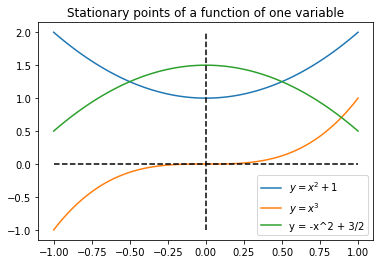

In [0]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 101)
y1 = np.power(x, 2) + 1
y2 = np.power(x, 3)
y3 = -np.power(x, 2) + 3/2

plt.plot(x, y1, label = r'$y = x^2 + 1$')
plt.plot(x, y2, label = r'$y = x^3$')
plt.plot(x, y3, label = r'y = -x^2 + 3/2')
plt.plot([-1, 1], [0, 0], color = 'black', linestyle = '--')
plt.plot([0, 0], [-1, 2], color = 'black', linestyle = '--')
plt.legend()
plt.title('Stationary points of a function of one variable')
plt.show()

The stationary points of functions of more than one variables are found in a similar way. If $f$ is a function of $x$ and $y$ then the stationary point of $f$ is *found* using the equations
$$
\begin{eqnarray}
\frac{\partial f}{\partial x} &=& 0 \tag{2} \\
\frac{\partial f}{\partial y} &=& 0 \tag{3}
\end{eqnarray}
$$
The nature of the stationary point is determined using the **Hessian matrix**
$$\tag{4}
H = \begin{pmatrix}
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial xy} \\ 
\frac{\partial^2 f}{\partial yx} & \frac{\partial^2 f}{\partial y^2}
\end{pmatrix}.
$$
If the solution to the equations (2) and (3) is $(a, b)$ then the
Hessian matrix is also computed at the same point. We then compute its determinant. If $D = \mathrm{det}(H(a,b))$ then

- If $D > 0$ and $\partial^2 f/\partial x^2$ computed at $(a, b)$ is positive then $(a, b)$ is a minimum.
- If $D > 0$ and $\partial^2 f/\partial x^2$ computed at $(a, b)$ is negative then $(a, b)$ is a maximum.
- If $D < 0$ then $(a, b)$ is a saddle point.
- If $D = 0$ then we cannot ascertain the nature of $(a, b)$ using this test.

If $f$ is a function of $n$ variables $x_1, \ldots, x_n$ then the stationary points are identified using the equations
$$\tag{5}
\frac{\partial f}{\partial x_i} = 0 \;\;\mathrm{for}\;i=1, \ldots, n
$$
The Hessian matrix is defined using
$$\tag{5}
H_{ij} = \frac{\partial^2f}{\partial x_i \partial x_j}.
$$
The nature of the stationary point is determined as:

- If $H$ is positive definite then $(a_1, \ldots, a_n)$ is a minimum.
- If $H$ is negative definite then $(a_1, \ldots, a_n)$ is a maximum.
- If $H$ has both positive and negative eigenvalues then $(a_1, \ldots, a_n)$ is a saddle point.
- If any eigenvalue of $H$ is zero then we cannot determine the nature of $(a_1, \ldots, a_n)$ using this rule. Refer to the [Wikipedia](https://en.wikipedia.org/wiki/Second_partial_derivative_test) page for an example of a maximum, a minimum and a saddle point.